# **Let's explore BBC News Archive**
#### **There're 5 categories --> Business, Entertainment, Tech, Politics and Sport**

In [ ]:
# http://mlg.ucd.ie/datasets/bbc.html    ----> URL to explore for the dataset

!pip install wget

import wget
url = "http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip"
wget.download(url, "/tmp/BBC_Raw.zip")

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=4b364a7c22ae7ea97a4d48504fdbb7ecdbee086b409c9358198d4956fb0e72a8
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


'/tmp/BBC_Raw.zip'

## **Now, let's work on Data Pre-Processing**

In [ ]:
import zipfile
import os
import pandas as pd

save_path = "/tmp/BBC_Raw.zip"
read_zip = zipfile.ZipFile(save_path, "r")
read_zip.extractall("/tmp")
read_zip.close()

business = os.listdir("/tmp/bbc/business")
entertainment = os.listdir("/tmp/bbc/entertainment")
politics = os.listdir("/tmp/bbc/politics")
sport = os.listdir("/tmp/bbc/sport")
tech = os.listdir("/tmp/bbc/tech")

print("Just For Information, 5 files name in Business category: \n", business[0:5])



lines2 = []
label = []
labels = ["business", "entertainment", "politics", "sport", "tech"]

for categry in labels:

  for_categry = os.listdir("/tmp/bbc/{}".format(categry))
  for name in for_categry:
    if(categry == "sport" and name == "199.txt"):   #As, having problem reading "199.txt"
      break;
    lines = ""
    for line in open(os.path.join("/tmp/bbc/{}".format(categry), name), "r"):
      lines = lines + line.replace("\n", " ").replace("\'", " ").replace("\"", " ").lower()
    # print(lines)
    lines2.append(lines)
    label.append("{}".format(categry))

df = pd.DataFrame(lines2, index = None)
df["category"] = label
df.rename(columns = {0 : "text"}, inplace = True)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
# df.head()
df = df.sample(frac =1)  #Return a random sample of items from an axis of object.
df.to_csv("/tmp/BBC_Preprocessed.csv", index = False)


Just For Information, 5 files name in Business category: 
 ['386.txt', '087.txt', '325.txt', '214.txt', '073.txt']


## **Removing the Stopwords**

In [ ]:
import csv

stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

category = []
text = []

with open("/tmp/BBC_Preprocessed.csv", "r") as my_file:
  reader = csv.reader(my_file, delimiter = ",")
  next(reader)
  for row in reader:
    category.append(row[0])
    sentence = row[1]
    for stopword in stopwords:
      unwanted = " " + stopword + " "
      sentence = sentence.replace(unwanted, " ")
      sentence = sentence.replace("  ", " ")
    text.append(sentence)

print("Number of sentences : ", len(text))
print("One sentence is: \n", text[0])

Number of sentences :  2039
One sentence is: 
 howard taunts blair splits tony blair s feud gordon brown damaging way uk governed, tory leader michael howard claimed heated prime minister s questions. mr howard asked: can fight crime fighting other? question later unveiled headline new tory campaign posters. mr blair dismissed talk splits said people s priorities next elections economic successes achieved labour. can stick whatever likes billboards something book public will concentrate low mortgages, low inflation, low unemployment delivered failed to, said. chancellor currently high-profile tour africa highlight new anti-poverty plans. so, insisted still trusted mr blair, despite claims contrary new book. brown s britain, robert peston, says mutual animosity two men. claims mr blair said november 2003 stand prime minister next election. went back pledge support cabinet allies suspicion mr brown manoeuvring him, says. mr peston s book claimed mr brown told mr blair: nothing ever say n

## **Let's build the Model**

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from IPython.display import display
# from IPython.html import widgets 
# from IPython.display import display
# from ipywidgets import interact, interactive, fixed, interact_manual



def My_model(vocab_size, embedding_dim, max_length):

  
  # vocab_size = 1000
  # embedding_dim = 16
  # max_length = 120
  trunc_type='post'
  padding_type='post'
  oov_tok = "<OOV>"
  training_portion = .8
  num_epochs = 30


  training_size = int(len(text) * training_portion)

  training_sentences = text[0:training_size]
  testing_sentences = text[training_size:]
  training_labels = category[0:training_size]
  testing_labels = category[training_size:]

  # Tokenizing Sentences
  token = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
  token.fit_on_texts(training_sentences)
  word_idx = token.word_index
  train_sequences = token.texts_to_sequences(training_sentences)
  train_padded = pad_sequences(train_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)
  test_sequences = token.texts_to_sequences(testing_sentences)
  test_padded = pad_sequences(test_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

  # Tokenizing Labels
  label_token = Tokenizer()
  label_token.fit_on_texts(category)
  labels_for_train = label_token.texts_to_sequences(training_labels)
  labels_for_test = label_token.texts_to_sequences(testing_labels)


  training_padded = np.array(train_padded)
  training_label = np.array(labels_for_train)
  testing_padded = np.array(test_padded)
  testing_label = np.array(labels_for_test)

  model = tf.keras.Sequential([
             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
             tf.keras.layers.GlobalAveragePooling1D(),
             tf.keras.layers.Dense(128, activation = "relu"),
             tf.keras.layers.Dropout(0.4),
             tf.keras.layers.Dense(6, activation = "softmax")                                   
  ])


  model.compile(optimizer = Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), 
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"])
  
  model.summary()


  early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose = 1, restore_best_weights=True)
  
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=10, verbose = 1,
    min_delta=0.01, min_lr=0.001)

  history = model.fit(training_padded, training_label, epochs = num_epochs, validation_data = (testing_padded, testing_label), callbacks = [early_stop, reduce_lr], verbose = 1)

  def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

  return model, token, word_idx

# interact(My_model, vocab_size=(1000, 10000, 2000), embedding_dim=(16, 40, 8), max_length=(16, 40, 8))

## **Let's run the model**

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d_6 ( (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               2176      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 774       
Total params: 18,950
Trainable params: 18,950
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
51/51 [==============================] - 0s 5ms/step - loss: 1.7540 - accuracy: 0.2544 - val_loss: 1.6995

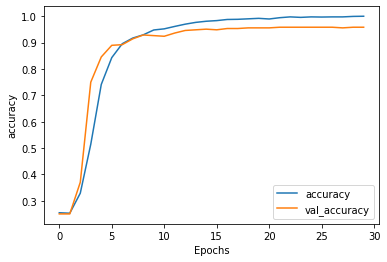

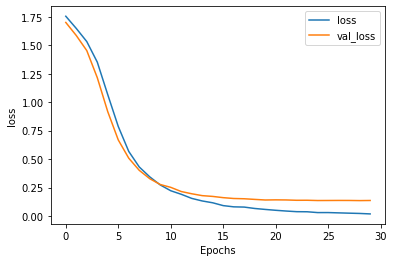

In [ ]:
vocab_size = 1000 
embedding_dim = 16 
max_length = 120

Model, tokenizer, word_index  = My_model(vocab_size, embedding_dim, max_length)

## **Now, creating Meta and Vacs (tsv file) for TensorFlow Projector**

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

e = Model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

assert(weights.shape == (vocab_size, embedding_dim))

(1000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Let's Test it**

In [ ]:
sentence = "tory leader unveils spending plan tory leader michael howard "
sentence2 = "Deep learning is evolving day by day, lot os stuffs to learn"
sentence3 = "our prime minister gave very nice sppech about the situation of our country"
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)
sequence2 = tokenizer.texts_to_sequences([sentence2])
print(sequence2)
sequence3 = tokenizer.texts_to_sequences([sentence3])
print(sequence3)
new_padded = pad_sequences(sequence3,maxlen=max_length)
Model.predict(new_padded)

[[315, 258, 1, 275, 490, 315, 258, 248, 193]]
[[1, 1, 1, 1, 105, 1, 105, 291, 1, 1, 439, 1]]
[[1, 177, 74, 884, 1, 1, 1, 1, 1, 913, 1, 1, 91]]


array([[3.3083043e-07, 1.3094142e-03, 9.5280409e-03, 6.3625276e-07,
        3.5243091e-05, 9.8912632e-01]], dtype=float32)

In [ ]:
new_padded = pad_sequences(sequence2,maxlen=max_length)
Model.predict(new_padded)

array([[2.2922634e-07, 3.8434219e-04, 2.8957285e-03, 6.2816014e-07,
        3.3159882e-05, 9.9668592e-01]], dtype=float32)